In [3]:
# imports
import pandas as pd
#import preproccesing
#import embeddings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
import gensim.downloader
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from imblearn.combine import SMOTEENN
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoModel
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score
import torch
import gc
import spacy
import ftfy
warnings.filterwarnings("ignore")

# Getting data ready

In [2]:
df = pd.read_csv("data_sample_nlp.csv")
df_en = df[df.language=='en'].copy()

In [3]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [4]:
df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

data=df_clean.copy()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220152 entries, 0 to 220151
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   label                    220152 non-null  object 
 1   id                       220152 non-null  object 
 2   author_id                220152 non-null  object 
 3   created_at               220152 non-null  object 
 4   type                     220152 non-null  object 
 5   text                     220152 non-null  object 
 6   language                 220152 non-null  object 
 7   geo_location             220152 non-null  object 
 8   referenced_tweets_types  220152 non-null  object 
 9   referenced_tweets_ids    220152 non-null  object 
 10  user_mentions            220152 non-null  object 
 11  media_types              220152 non-null  object 
 12  in_reply_to_user_id      54415 non-null   float64
 13  possibly_sensitive       220152 non-null  object 
dtypes: f

In [7]:
X = data.text
y = data.label.map(lambda x: 1 if x=='bot' else 0)

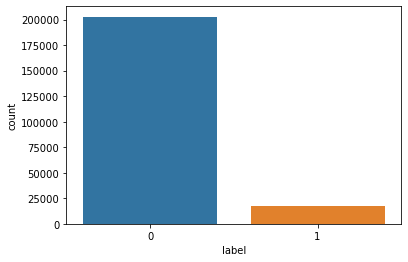

Imbalance: 0.07899996366147026


In [8]:
# positive class
sns.countplot(x=y)
plt.show()
print(f'Imbalance: {sum(y)/len(y)}')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

# Bench mark

## Count vectorizer

Creates a dictionary with the top 10000 words in the training corpus according to frequency. We use this to get a first benchmark after doing nothing to the data

In [13]:
vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [15]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     81179
           1       0.22      0.02      0.03      6882

    accuracy                           0.92     88061
   macro avg       0.57      0.51      0.49     88061
weighted avg       0.87      0.92      0.89     88061



Very poor performance, mostly due to the imbalance of the classes

# Balancing the classes

## Down sampling

In [20]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.0857).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [24]:
df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

In [25]:
data=df_clean.copy()

In [26]:
X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)

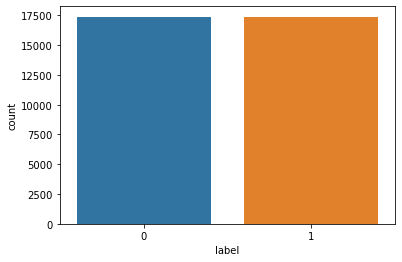

Imbalance: 0.5002157093963013


In [27]:
# positive class
sns.countplot(x=y_balanced)
plt.show()
print(f'Imbalance: {sum(y_balanced)/len(y_balanced)}')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X_balanced, 
                                                    y_balanced, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

### Count vectorizer

Creates a dictionary with the top 10000 words in the training corpus according to frequency. We use this to get a first benchmark after doing nothing to the data

In [29]:
vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [31]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.55      0.53      0.54      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



We got rid of the overfitting, and now we have a very poor classifier. Let's try SMOTEEN balancing before trying different things to better our model

## SMOTEEN 

For memory reasons, we have to downsample a little bit

In [41]:
# downsampling a little bit

bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.3).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

df_clean = preproccesing.preprocessing(
                                        df=df_small,
                                        lowercase=False, 
                                        stopwords=False, 
                                        links=False, 
                                        tags=False, 
                                        numbers=False, 
                                        emojis=False, 
                                        hashtag=False,
                                        rt=False
                                       ).copy()

data=df_clean.copy()

X = data.text
y = data.label.map(lambda x: 1 if x=='bot' else 0)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )

vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
vectorizer.fit(X_train)

CountVectorizer(max_features=10000)

In [43]:
# smoteen
sme = SMOTEENN(random_state=42)
X_sme, y_sme = sme.fit_resample(vectorizer.transform(X_train).toarray(), y_train)

In [46]:
sum(y_train)/len(y_train)

0.22351487258160743

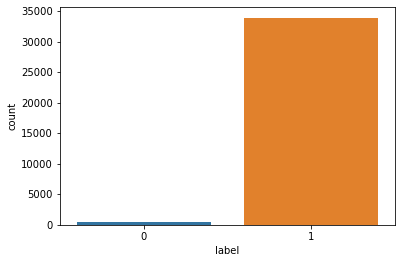

Imbalance: 0.9878752550276887


In [47]:
# positive class
sns.countplot(x=y_sme)
plt.show()
print(f'Imbalance: {sum(y_sme)/len(y_sme)}')

In [49]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(X_sme, y_sme)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.83      0.01      0.02     24386
           1       0.22      0.99      0.36      6902

    accuracy                           0.23     31288
   macro avg       0.53      0.50      0.19     31288
weighted avg       0.70      0.23      0.10     31288



This is taking a lot of time and requires more work as right now is changing the imbalance of the classes (i.e. is not working). I'll move on for now and return to this later 

# Cleaning

We stick to the downsampled dataset and now measure the impact of cleanning on performance

In [50]:
bots = df_en[df_en.label=='bot'].copy()
humans = df_en[df_en.label=='human'].sample(frac=0.0857).copy()
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')

In [60]:
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}

for p, v in zip(params.keys(), params.values()):
    args = params.copy()
    args[p] = not v
    df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
    data=df_clean.copy()
    
    X_balanced = data.text
    y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
    
    X_train, X_test, y_train, y_test = train_test_split(
                                                    X_balanced, 
                                                    y_balanced, 
                                                    test_size=0.4, 
                                                    random_state=42
                                                   )
    
    vectorizer = CountVectorizer(max_features=10000, 
                             lowercase=True)
    vectorizer.fit(X_train)
    
    # here's a simple classifier, we can try different ones
    lg = LogisticRegression()
    lg.fit(vectorizer.transform(X_train).toarray(), y_train)
    print(p, args[p])
    print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))
    print('\n')

stopwords True
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



links True
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



tags True
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      6947
           1       0.54      0.52      0.53      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54 

In [61]:
# effect of combined cleanning
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
args = params.copy()
for p, v in zip(params.keys(), params.values()):
    args[p] = not v

print(args)
df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
data=df_clean.copy()


X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)


X_train, X_test, y_train, y_test = train_test_split(
                                        X_balanced, 
                                        y_balanced, 
                                        test_size=0.4, 
                                        random_state=42
                                    )


vectorizer = CountVectorizer(max_features=10000, 
                                lowercase=True)
vectorizer.fit(X_train)


# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

{'stopwords': True, 'links': True, 'tags': True, 'numbers': True, 'emojis': True, 'hashtag': True, 'rt': True}
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      6947
           1       0.53      0.54      0.54      6961

    accuracy                           0.53     13908
   macro avg       0.53      0.53      0.53     13908
weighted avg       0.53      0.53      0.53     13908





# Representations

So far, we have been able to improve our model's performance by downsampling the majority class. We also learnt that preprocessing, altghough useful, isn't going to radically change the classification performance. We have done this using the simplest of encoders (Count Vectorizer) and a very simple model (Logistic Regression).

Now that we know this approaches won't be enough, it's time to get more sophisticated. 

We'll start by using a better counting encoder: Tfidf Vectorizer. If we don't see enough improvement, we'll finally move to transformers. 

In [2]:
# data
bots = pd.read_csv('bots_100k.csv')
humans = pd.read_csv('bots_100k.csv')
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')
params = {'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
args = params.copy()
#for p, v in zip(params.keys(), params.values()):
#    args[p] = not v
df_clean = preproccesing.preprocessing(df=df_small, **args).copy()
data=df_clean.copy()
X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
#X_train, X_test, y_train, y_test = train_test_split(
#                                        X_balanced, 
#                                        y_balanced, 
#                                        test_size=0.4, 
#                                        random_state=42
#                                    )

## Tfidf Vectorizer

In [4]:
vectorizer = TfidfVectorizer(max_features=10000)
vectorizer.fit(X_balanced)

TfidfVectorizer(max_features=10000)

In [64]:
# here's a simple classifier, we can try different ones
lg = LogisticRegression()
lg.fit(vectorizer.transform(X_train).toarray(), y_train)
print(classification_report(y_test, lg.predict(vectorizer.transform(X_test))))

              precision    recall  f1-score   support

           0       0.54      0.53      0.53      6947
           1       0.54      0.55      0.55      6961

    accuracy                           0.54     13908
   macro avg       0.54      0.54      0.54     13908
weighted avg       0.54      0.54      0.54     13908



Once again, no improvement. Let's go to the transformers

## Transformers

Note that we'll test first without cleaning and then with full cleaning. But before doing that, we'll stick with the top 10k most frequent words for memory reasons. To do that, we can use the Tfidf Vectorizer we just trained

In [10]:
del bots, humans, df_small, df_clean, data, X_balanced, y_balanced
gc.collect()

60

In [2]:
bots = pd.read_csv('bots_100k.csv')
humans = pd.read_csv('human_100k.csv')
df_small = pd.concat([bots,humans]).reset_index().drop(columns='index')
params = {'lowercase':False,
          'stopwords':False, 
          'links':False, 
          'tags':False, 
          'numbers':False, 
          'emojis':False, 
          'hashtag':False,
          'rt':False}
df_clean = preproccesing.preprocessing(df=df_small, **params).copy()
data=df_clean.copy()

X_balanced = data.text
y_balanced = data.label.map(lambda x: 1 if x=='bot' else 0)
X_train, X_test, y_train, y_test = train_test_split(
                                        X_balanced, 
                                        y_balanced, 
                                        test_size=0.4, 
                                        random_state=42
                                    )

In [5]:
def get_representation(data, 
                       model_name='distilbert-base-uncased', 
                       splits=30):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    tokens = tokenizer(list(data.values),
                   truncation=True, 
                   max_length=128,
                   return_tensors='pt', 
                   padding=True)
    
    ids = np.array_split(tokens.input_ids, splits)
    attentions = np.array_split(tokens.attention_mask, splits)
    emb_dim = model.config.dim
    representation = np.zeros((1,emb_dim))
    i = 0
    for batch_input, batch_attention in zip(ids, attentions):
        embd_batch = model(input_ids=batch_input,
                           attention_mask=batch_attention,
                           output_attentions=False, 
                           output_hidden_states=False)
        # tweet representation
        mean_emb_batch = torch.mean(embd_batch.last_hidden_state, axis=1)
        
        representation_batch = mean_emb_batch.detach().numpy()
        representation = np.concatenate((representation, representation_batch), axis=0)
        del embd_batch, mean_emb_batch, representation_batch
        gc.collect()
        i+=1
        print(f'Done {i}/{splits}')
    gc.collect() 
    return representation[1:,:]
        

### distilbert-base-uncased

In [6]:
X_train_emb = get_representation(data=X_train, 
                                 model_name='distilbert-base-uncased', 
                                 splits=200)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/200
Done 2/200
Done 3/200
Done 4/200
Done 5/200
Done 6/200
Done 7/200
Done 8/200
Done 9/200
Done 10/200
Done 11/200
Done 12/200
Done 13/200
Done 14/200
Done 15/200
Done 16/200
Done 17/200
Done 18/200
Done 19/200
Done 20/200
Done 21/200
Done 22/200
Done 23/200
Done 24/200
Done 25/200
Done 26/200
Done 27/200
Done 28/200
Done 29/200
Done 30/200
Done 31/200
Done 32/200
Done 33/200
Done 34/200
Done 35/200
Done 36/200
Done 37/200
Done 38/200
Done 39/200
Done 40/200
Done 41/200
Done 42/200
Done 43/200
Done 44/200
Done 45/200
Done 46/200
Done 47/200
Done 48/200
Done 49/200
Done 50/200
Done 51/200
Done 52/200
Done 53/200
Done 54/200
Done 55/200
Done 56/200
Done 57/200
Done 58/200
Done 59/200
Done 60/200
Done 61/200
Done 62/200
Done 63/200
Done 64/200
Done 65/200
Done 66/200
Done 67/200
Done 68/200
Done 69/200
Done 70/200
Done 71/200
Done 72/200
Done 73/200
Done 74/200
Done 75/200
Done 76/200
Done 77/200
Done 78/200
Done 79/200
Done 80/200
Done 81/200
Done 82/200
Done 83/200
Done 84/200
D

In [9]:
X_test_emb = get_representation(data=X_test, 
                                 model_name='distilbert-base-uncased', 
                                 splits=200)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/200
Done 2/200
Done 3/200
Done 4/200
Done 5/200
Done 6/200
Done 7/200
Done 8/200
Done 9/200
Done 10/200
Done 11/200
Done 12/200
Done 13/200
Done 14/200
Done 15/200
Done 16/200
Done 17/200
Done 18/200
Done 19/200
Done 20/200
Done 21/200
Done 22/200
Done 23/200
Done 24/200
Done 25/200
Done 26/200
Done 27/200
Done 28/200
Done 29/200
Done 30/200
Done 31/200
Done 32/200
Done 33/200
Done 34/200
Done 35/200
Done 36/200
Done 37/200
Done 38/200
Done 39/200
Done 40/200
Done 41/200
Done 42/200
Done 43/200
Done 44/200
Done 45/200
Done 46/200
Done 47/200
Done 48/200
Done 49/200
Done 50/200
Done 51/200
Done 52/200
Done 53/200
Done 54/200
Done 55/200
Done 56/200
Done 57/200
Done 58/200
Done 59/200
Done 60/200
Done 61/200
Done 62/200
Done 63/200
Done 64/200
Done 65/200
Done 66/200
Done 67/200
Done 68/200
Done 69/200
Done 70/200
Done 71/200
Done 72/200
Done 73/200
Done 74/200
Done 75/200
Done 76/200
Done 77/200
Done 78/200
Done 79/200
Done 80/200
Done 81/200
Done 82/200
Done 83/200
Done 84/200
D

In [31]:
# test different models

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
kn = KNeighborsClassifier()

all_models = {"RandomForest":rf, "LogisticRegression":lr, "K-Neighbors":kn}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train_emb, 
                            y_train, 
                            cv=5,
                            scoring=["f1"])
    print(name + " with mean accuracy over 5 folds of: " + str(round(np.mean(cv_results["test_f1"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_f1"]),4)))

RandomForest with mean accuracy over 5 folds of: 0.5738 and sigma accross test metrics of: 0.0025
LogisticRegression with mean accuracy over 5 folds of: 0.5861 and sigma accross test metrics of: 0.0024
K-Neighbors with mean accuracy over 5 folds of: 0.6068 and sigma accross test metrics of: 0.0037


The best model was K-Neighbors with an estimated f1-score over 5-fold cross validation of 0.61 +- 0.004
\
\
Now we estimate its performance on the test set

In [32]:
model = KNeighborsClassifier()
model.fit(X_train_emb, y_train)
print(classification_report(y_test, model.predict(X_test_emb)))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62     40206
           1       0.61      0.60      0.61     39797

    accuracy                           0.61     80003
   macro avg       0.61      0.61      0.61     80003
weighted avg       0.61      0.61      0.61     80003



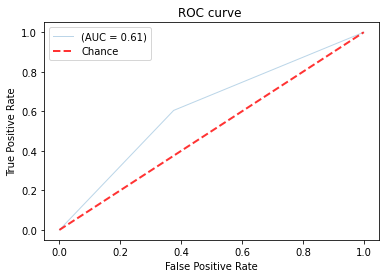

In [33]:
# ROC curve
y_true = y_test
y_pre = model.predict(X_test_emb)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

### gpt2

In [3]:
def get_representation(data, 
                       model_name='distilbert-base-uncased', 
                       splits=30):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model = AutoModel.from_pretrained(model_name)
    model.resize_token_embeddings(len(tokenizer))
    tokens = tokenizer(list(data.values),
                   truncation=True, 
                   max_length=128,
                   return_tensors='pt', 
                   padding=True)
    
    ids = np.array_split(tokens.input_ids, splits)
    attentions = np.array_split(tokens.attention_mask, splits)
    emb_dim = model.config.n_embd 
    representation = np.zeros((1,emb_dim))
    i = 0
    for batch_input, batch_attention in zip(ids, attentions):
        embd_batch = model(input_ids=batch_input,
                           attention_mask=batch_attention,
                           output_attentions=False, 
                           output_hidden_states=False)
        # tweet representation
        mean_emb_batch = torch.mean(embd_batch.last_hidden_state, axis=1)
        
        representation_batch = mean_emb_batch.detach().numpy()
        representation = np.concatenate((representation, representation_batch), axis=0)
        del embd_batch, mean_emb_batch, representation_batch
        gc.collect()
        i+=1
        print(f'Done {i}/{splits}')
    gc.collect() 
    return representation[1:,:]
        

In [4]:
X_train_emb_gpt = get_representation(data=X_train, 
                                     model_name='gpt2', 
                                     splits=500)

Done 1/500
Done 2/500
Done 3/500
Done 4/500
Done 5/500
Done 6/500
Done 7/500
Done 8/500
Done 9/500
Done 10/500
Done 11/500
Done 12/500
Done 13/500
Done 14/500
Done 15/500
Done 16/500
Done 17/500
Done 18/500
Done 19/500
Done 20/500
Done 21/500
Done 22/500
Done 23/500
Done 24/500
Done 25/500
Done 26/500
Done 27/500
Done 28/500
Done 29/500
Done 30/500
Done 31/500
Done 32/500
Done 33/500
Done 34/500
Done 35/500
Done 36/500
Done 37/500
Done 38/500
Done 39/500
Done 40/500
Done 41/500
Done 42/500
Done 43/500
Done 44/500
Done 45/500
Done 46/500
Done 47/500
Done 48/500
Done 49/500
Done 50/500
Done 51/500
Done 52/500
Done 53/500
Done 54/500
Done 55/500
Done 56/500
Done 57/500
Done 58/500
Done 59/500
Done 60/500
Done 61/500
Done 62/500
Done 63/500
Done 64/500
Done 65/500
Done 66/500
Done 67/500
Done 68/500
Done 69/500
Done 70/500
Done 71/500
Done 72/500
Done 73/500
Done 74/500
Done 75/500
Done 76/500
Done 77/500
Done 78/500
Done 79/500
Done 80/500
Done 81/500
Done 82/500
Done 83/500
Done 84/500
D

In [6]:
X_test_emb_gpt = get_representation(data=X_test, 
                                    model_name='gpt2', 
                                    splits=500)

Done 1/500
Done 2/500
Done 3/500
Done 4/500
Done 5/500
Done 6/500
Done 7/500
Done 8/500
Done 9/500
Done 10/500
Done 11/500
Done 12/500
Done 13/500
Done 14/500
Done 15/500
Done 16/500
Done 17/500
Done 18/500
Done 19/500
Done 20/500
Done 21/500
Done 22/500
Done 23/500
Done 24/500
Done 25/500
Done 26/500
Done 27/500
Done 28/500
Done 29/500
Done 30/500
Done 31/500
Done 32/500
Done 33/500
Done 34/500
Done 35/500
Done 36/500
Done 37/500
Done 38/500
Done 39/500
Done 40/500
Done 41/500
Done 42/500
Done 43/500
Done 44/500
Done 45/500
Done 46/500
Done 47/500
Done 48/500
Done 49/500
Done 50/500
Done 51/500
Done 52/500
Done 53/500
Done 54/500
Done 55/500
Done 56/500
Done 57/500
Done 58/500
Done 59/500
Done 60/500
Done 61/500
Done 62/500
Done 63/500
Done 64/500
Done 65/500
Done 66/500
Done 67/500
Done 68/500
Done 69/500
Done 70/500
Done 71/500
Done 72/500
Done 73/500
Done 74/500
Done 75/500
Done 76/500
Done 77/500
Done 78/500
Done 79/500
Done 80/500
Done 81/500
Done 82/500
Done 83/500
Done 84/500
D

In [7]:
# test different models

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
kn = KNeighborsClassifier()

all_models = {"RandomForest":rf, "LogisticRegression":lr, "K-Neighbors":kn}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train_emb_gpt, 
                            y_train, 
                            cv=5,
                            scoring=["f1"])
    print(name + " with mean accuracy over 5 folds of: " + str(round(np.mean(cv_results["test_f1"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_f1"]),4)))

RandomForest with mean accuracy over 5 folds of: 0.5746 and sigma accross test metrics of: 0.0012
LogisticRegression with mean accuracy over 5 folds of: 0.5889 and sigma accross test metrics of: 0.0024
K-Neighbors with mean accuracy over 5 folds of: 0.5449 and sigma accross test metrics of: 0.0034


In [11]:
model = XGBClassifier()
model.fit(X_train_emb_gpt, y_train)
print(classification_report(y_test, model.predict(X_test_emb_gpt)))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     40206
           1       0.60      0.59      0.59     39797

    accuracy                           0.60     80003
   macro avg       0.60      0.60      0.60     80003
weighted avg       0.60      0.60      0.60     80003



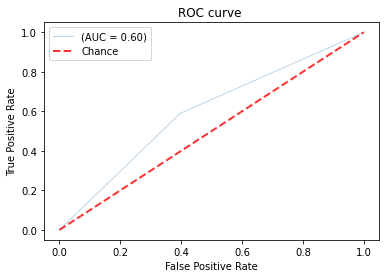

In [12]:
# ROC curve
y_true = y_test
y_pre = model.predict(X_test_emb_gpt)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

### roberta-base

In [3]:
def get_representation(data, 
                       model_name='distilbert-base-uncased', 
                       splits=30):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    tokens = tokenizer(list(data.values),
                   truncation=True, 
                   max_length=128,
                   return_tensors='pt', 
                   padding=True)
    
    ids = np.array_split(tokens.input_ids, splits)
    attentions = np.array_split(tokens.attention_mask, splits)
    emb_dim = model.config.hidden_size 
    representation = np.zeros((1,emb_dim))
    i = 0
    for batch_input, batch_attention in zip(ids, attentions):
        embd_batch = model(input_ids=batch_input,
                           attention_mask=batch_attention,
                           output_attentions=False, 
                           output_hidden_states=False)
        # tweet representation
        mean_emb_batch = torch.mean(embd_batch.last_hidden_state, axis=1)
        
        representation_batch = mean_emb_batch.detach().numpy()
        representation = np.concatenate((representation, representation_batch), axis=0)
        del embd_batch, mean_emb_batch, representation_batch
        gc.collect()
        i+=1
        print(f'Done {i}/{splits}')
    gc.collect() 
    return representation[1:,:]

In [4]:
X_train_emb_rob = get_representation(data=X_train, 
                                     model_name='roberta-base', 
                                     splits=250)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/250
Done 2/250
Done 3/250
Done 4/250
Done 5/250
Done 6/250
Done 7/250
Done 8/250
Done 9/250
Done 10/250
Done 11/250
Done 12/250
Done 13/250
Done 14/250
Done 15/250
Done 16/250
Done 17/250
Done 18/250
Done 19/250
Done 20/250
Done 21/250
Done 22/250
Done 23/250
Done 24/250
Done 25/250
Done 26/250
Done 27/250
Done 28/250
Done 29/250
Done 30/250
Done 31/250
Done 32/250
Done 33/250
Done 34/250
Done 35/250
Done 36/250
Done 37/250
Done 38/250
Done 39/250
Done 40/250
Done 41/250
Done 42/250
Done 43/250
Done 44/250
Done 45/250
Done 46/250
Done 47/250
Done 48/250
Done 49/250
Done 50/250
Done 51/250
Done 52/250
Done 53/250
Done 54/250
Done 55/250
Done 56/250
Done 57/250
Done 58/250
Done 59/250
Done 60/250
Done 61/250
Done 62/250
Done 63/250
Done 64/250
Done 65/250
Done 66/250
Done 67/250
Done 68/250
Done 69/250
Done 70/250
Done 71/250
Done 72/250
Done 73/250
Done 74/250
Done 75/250
Done 76/250
Done 77/250
Done 78/250
Done 79/250
Done 80/250
Done 81/250
Done 82/250
Done 83/250
Done 84/250
D

In [5]:
X_test_emb_rob = get_representation(data=X_test, 
                                    model_name='roberta-base', 
                                    splits=250)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Done 1/250
Done 2/250
Done 3/250
Done 4/250
Done 5/250
Done 6/250
Done 7/250
Done 8/250
Done 9/250
Done 10/250
Done 11/250
Done 12/250
Done 13/250
Done 14/250
Done 15/250
Done 16/250
Done 17/250
Done 18/250
Done 19/250
Done 20/250
Done 21/250
Done 22/250
Done 23/250
Done 24/250
Done 25/250
Done 26/250
Done 27/250
Done 28/250
Done 29/250
Done 30/250
Done 31/250
Done 32/250
Done 33/250
Done 34/250
Done 35/250
Done 36/250
Done 37/250
Done 38/250
Done 39/250
Done 40/250
Done 41/250
Done 42/250
Done 43/250
Done 44/250
Done 45/250
Done 46/250
Done 47/250
Done 48/250
Done 49/250
Done 50/250
Done 51/250
Done 52/250
Done 53/250
Done 54/250
Done 55/250
Done 56/250
Done 57/250
Done 58/250
Done 59/250
Done 60/250
Done 61/250
Done 62/250
Done 63/250
Done 64/250
Done 65/250
Done 66/250
Done 67/250
Done 68/250
Done 69/250
Done 70/250
Done 71/250
Done 72/250
Done 73/250
Done 74/250
Done 75/250
Done 76/250
Done 77/250
Done 78/250
Done 79/250
Done 80/250
Done 81/250
Done 82/250
Done 83/250
Done 84/250
D

In [6]:
# test different models

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
kn = KNeighborsClassifier()

all_models = {"RandomForest":rf, "LogisticRegression":lr, "K-Neighbors":kn}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train_emb_rob, 
                            y_train, 
                            cv=5,
                            scoring=["f1"])
    print(name + " with mean accuracy over 5 folds of: " + str(round(np.mean(cv_results["test_f1"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_f1"]),4)))

RandomForest with mean accuracy over 5 folds of: 0.5796 and sigma accross test metrics of: 0.004
LogisticRegression with mean accuracy over 5 folds of: 0.5889 and sigma accross test metrics of: 0.0026
K-Neighbors with mean accuracy over 5 folds of: 0.5944 and sigma accross test metrics of: 0.002


The best model was K-Neighbors with an estimated f1-score over 5-fold cross validation of 0.59 +- 0.002
\
\
Now we estimate its performance on the test set

In [8]:
model = KNeighborsClassifier()
model.fit(X_train_emb_rob, y_train)
print(classification_report(y_test, model.predict(X_test_emb_rob)))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61     40206
           1       0.60      0.59      0.60     39797

    accuracy                           0.60     80003
   macro avg       0.60      0.60      0.60     80003
weighted avg       0.60      0.60      0.60     80003



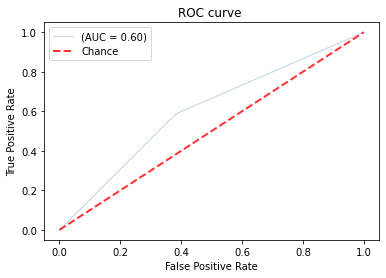

In [9]:
# ROC curve
y_true = y_test
y_pre = model.predict(X_test_emb_rob)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

# Future work

Due to time constraints, we couldn't test the following steps that we think could have an impact on the task's performance:

* More data. Although we went from ~30k datapoints to ~100k, we would have wanted to increase the amount of data even further. As we saw throughout the project, increasing the number of observations significantly improved our models' performance. This, however, was limited by the time required to process large amounts of text, taking up to 8+ hours to get the representation of the training data. 
* 3-dimensional tweet representation. Every time we collapsed a tweet into a 2-dimensional tensor by taking the average of the token's embedding, we lost information. This wasn't a huge problem as the task at hand does not rely on contextual information as we are not trying to classify words within sentences (unlike a NER problem) but rather the whole tweet. However, the extra information could have made a difference.
* A neural network architecture 